In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Set the train and test folders
train_folder = 'C:/Users/shash/Documents/MScA/Courses/Spring 2021/Machine Learning/Project/archive/chest_xray/train/'
val_folder = 'C:/Users/shash/Documents/MScA/Courses/Spring 2021/Machine Learning/Project/archive/chest_xray/val/'
test_folder = 'C:/Users/shash/Documents/MScA/Courses/Spring 2021/Machine Learning/Project/archive/chest_xray/test/'

In [3]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [4]:
training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (180, 180),
                                                 batch_size = 32,
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')


validation_set = train_datagen.flow_from_directory(val_folder,
                                                 target_size = (180, 180),
                                                 batch_size = 32,
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')

test_set = train_datagen.flow_from_directory(test_folder,
                                                 target_size = (180, 180),
                                                 batch_size = 32,
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


[[216 217 218 ...  11  11  12]
 [218 219 220 ...  12  12  12]
 [219 220 221 ...  12  13  14]
 ...
 [ 23  23  23 ...  13  13  13]
 [ 23  23  23 ...  13  13  13]
 [ 23  23  23 ...  13  13  13]]
640


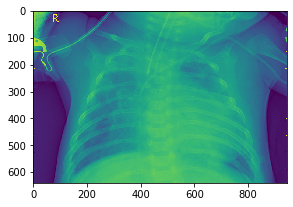

In [5]:
image = cv2.imread("C:/Users/shash/Documents/MScA/Courses/Spring 2021/Machine Learning/Project/archive/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg", cv2.IMREAD_GRAYSCALE)
print(image)
print(len(image))
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(image)

In [6]:
#Let's get the number of classes to predict
training_set.class_indices
# As can be seen, there are 4 classes of images to predict

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
training_set.image_shape

(180, 180, 1)

#### Configure data for performance

In [8]:
# AUTOTUNE = tf.data.AUTOTUNE

# training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

### ANN

In [9]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

early_stopping = EarlyStopping(
    patience=7, restore_best_weights=True
)
ckpt1 = ModelCheckpoint(
    filepath = './saved_model/checkpoint1/',
    save_best_only = True
)

In [10]:
ann = models.Sequential([
        layers.Flatten(input_shape=[180,180,1]),
        layers.Dense(1000, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
ann.compile(optimizer='SGD',
              loss='categorical_crossentropy', #sparse_categorical_crossentropy loss function is not working here
              metrics=METRICS)

In [11]:
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 32400)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              32401000  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 32,511,402
Trainable params: 32,511,402
Non-trainable params: 0
_________________________________________________________________


In [12]:
history1 = ann.fit(training_set, epochs = 50, validation_data = validation_set, callbacks=[ckpt1, early_stopping])

Epoch 1/50
163/163 [==============================] - 52s 314ms/step - loss: 0.5274 - accuracy: 0.7552 - precision: 0.7552 - recall: 0.7552 - val_loss: 0.6133 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250
INFO:tensorflow:Assets written to: ./saved_model/checkpoint1\assets
Epoch 2/50
163/163 [==============================] - 51s 312ms/step - loss: 0.4167 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - val_loss: 0.7440 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 3/50
163/163 [==============================] - 51s 311ms/step - loss: 0.3543 - accuracy: 0.8434 - precision: 0.8434 - recall: 0.8434 - val_loss: 0.5555 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 0.6875
INFO:tensorflow:Assets written to: ./saved_model/checkpoint1\assets
Epoch 4/50
163/163 [==============================] - 51s 312ms/step - loss: 0.3177 - accuracy: 0.8618 - precision: 0.8618 - recall: 0.8618 - val_loss: 0.6237 - val_accuracy: 0.6875 -

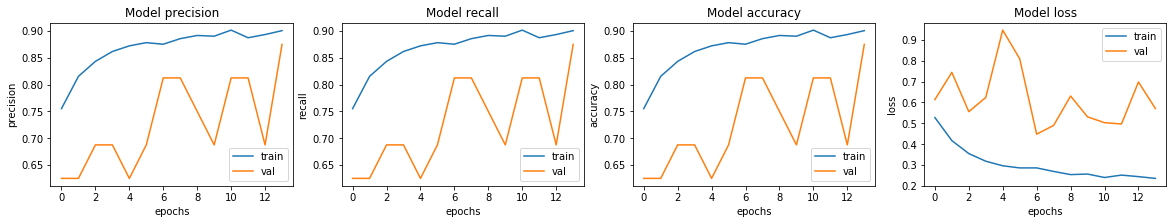

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [14]:
loss, acc, prec, rec = ann.evaluate(test_set)

20/20 [==============================] - 5s 264ms/step - loss: 0.4000 - accuracy: 0.8221 - precision: 0.8221 - recall: 0.8221


In [15]:
print('test loss = ', loss)
print('test accuracy = ', acc)
print('test precision = ', prec)
print('test recall = ', rec)

test loss =  0.39996495842933655
test accuracy =  0.8221153616905212
test precision =  0.8221153616905212
test recall =  0.8221153616905212


### CNN

In [16]:
# CNN Model 1

cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 1), padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'), ## split 64 into 32 and 16 to avoid overfitting
    layers.Dense(2, activation='softmax')
])
cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

In [17]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2073632   
_________________________________________________________________
dense_5 (Dense)              (None, 32)               

In [18]:
early_stopping = EarlyStopping(
    patience=7, restore_best_weights=True
)
ckpt2 = ModelCheckpoint(
    filepath = './saved_model/checkpoint2/',
    save_best_only = True
)

In [19]:
history2 = cnn.fit(training_set, validation_data = validation_set, epochs = 50, callbacks=[ckpt2, early_stopping])

Epoch 1/50
163/163 [==============================] - 55s 322ms/step - loss: 0.3629 - accuracy: 0.8470 - precision: 0.8443 - recall: 0.8443 - val_loss: 0.6836 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500
INFO:tensorflow:Assets written to: ./saved_model/checkpoint2\assets
Epoch 2/50
163/163 [==============================] - 53s 322ms/step - loss: 0.2327 - accuracy: 0.9076 - precision: 0.9076 - recall: 0.9076 - val_loss: 0.8411 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 0.6875
Epoch 3/50
163/163 [==============================] - 52s 321ms/step - loss: 0.1887 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - val_loss: 0.8828 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 0.8125
Epoch 4/50
163/163 [==============================] - 52s 320ms/step - loss: 0.1589 - accuracy: 0.9354 - precision: 0.9354 - recall: 0.9354 - val_loss: 0.5232 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500
INFO:tensorflow:Assets w

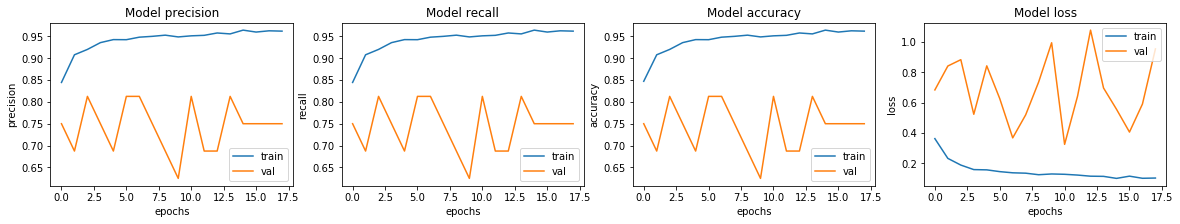

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
loss, acc, prec, rec = cnn.evaluate(test_set)

20/20 [==============================] - 5s 259ms/step - loss: 0.4376 - accuracy: 0.8526 - precision: 0.8526 - recall: 0.8526


In [22]:
print('test loss = ', loss)
print('test accuracy = ', acc)
print('test precision = ', prec)
print('test recall = ', rec)

test loss =  0.4376316964626312
test accuracy =  0.8525640964508057
test precision =  0.8525640964508057
test recall =  0.8525640964508057


#### CNN model 2

In [23]:
# CNN Model 2
cnn1 = Sequential()
#Convolution
cnn1.add(Conv2D(32, (3, 3), activation="relu", input_shape=(180, 180, 1)))
#Pooling
cnn1.add(MaxPooling2D(pool_size = (2, 2)))
# 2nd Convolution
cnn1.add(Conv2D(32, (3, 3), activation="relu"))
# 2nd Pooling layer
cnn1.add(MaxPooling2D(pool_size = (2, 2)))
# Flatten the layer
cnn1.add(Flatten())
# Fully Connected Layers
cnn1.add(Dense(activation = 'relu', units = 128))
cnn1.add(Dense(activation = 'sigmoid', units = 2))
# Compile the Neural network
cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=METRICS)

In [24]:
cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 59168)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7573632   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [25]:
early_stopping = EarlyStopping(
    patience=7, restore_best_weights=True
)
ckpt3 = ModelCheckpoint(
    filepath = './saved_model/checkpoint3/',
    save_best_only = True
)

In [26]:
history3 = cnn1.fit(training_set, validation_data = validation_set, epochs = 50, callbacks=[ckpt3, early_stopping])

Epoch 1/50
163/163 [==============================] - 61s 313ms/step - loss: 0.5318 - accuracy: 0.7672 - precision: 0.8010 - recall: 0.7547 - val_loss: 1.0062 - val_accuracy: 0.5625 - val_precision: 0.8368 - val_recall: 0.8161
INFO:tensorflow:Assets written to: ./saved_model/checkpoint3\assets
Epoch 2/50
163/163 [==============================] - 51s 314ms/step - loss: 0.2260 - accuracy: 0.9057 - precision: 0.8483 - recall: 0.8309 - val_loss: 0.8090 - val_accuracy: 0.6875 - val_precision: 0.8751 - val_recall: 0.8641
INFO:tensorflow:Assets written to: ./saved_model/checkpoint3\assets
Epoch 3/50
163/163 [==============================] - 52s 319ms/step - loss: 0.1839 - accuracy: 0.9264 - precision: 0.8804 - recall: 0.8705 - val_loss: 0.8149 - val_accuracy: 0.6250 - val_precision: 0.8914 - val_recall: 0.8838
Epoch 4/50
163/163 [==============================] - 52s 316ms/step - loss: 0.1502 - accuracy: 0.9424 - precision: 0.8951 - recall: 0.8879 - val_loss: 1.1100 - val_accuracy: 0.6250 -

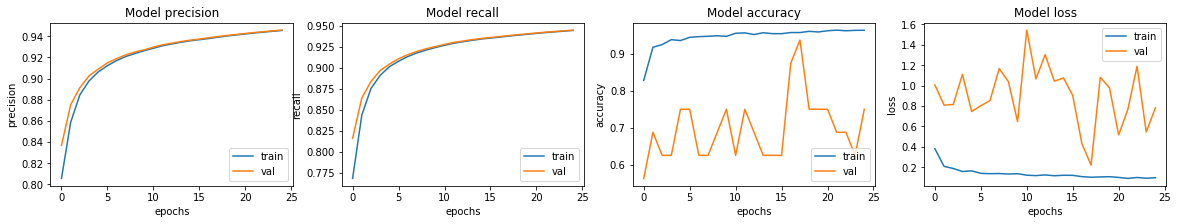

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, acc, prec, rec = cnn1.evaluate(test_set)

20/20 [==============================] - 5s 264ms/step - loss: 0.3572 - accuracy: 0.8782 - precision: 0.9456 - recall: 0.9449


In [29]:
print('test loss = ', loss)
print('test accuracy = ', acc)
print('test precision = ', prec)
print('test recall = ', rec)

test loss =  0.35715538263320923
test accuracy =  0.8782051205635071
test precision =  0.9456257820129395
test recall =  0.9449315071105957


#### CNN Model 3

In [30]:
# Let's build the CNN model
# this is my original model

classifier = Sequential()

#Convolution layer
classifier.add(Conv2D(filters = 32, kernel_size = (3,3), activation="relu", input_shape=(180,180,1), padding="same"))

#pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

#2nd Convolution
classifier.add(Conv2D(filters=64,kernel_size = (3,3),activation = "relu", padding='same'))

#pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

#flatten
classifier.add(Flatten())

# Fully Connected Layers
classifier.add(Dense(activation = 'relu', units = 128))
classifier.add(Dense(activation = 'sigmoid', units = 2))

#Compile
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)


In [31]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 129600)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16588928  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [32]:
early_stopping = EarlyStopping(
    patience=7, restore_best_weights=True
)
ckpt4 = ModelCheckpoint(
    filepath = './saved_model/checkpoint4/',
    save_best_only = True
)

In [33]:
history4 = classifier.fit(training_set, validation_data = validation_set, 
                          epochs = 50, callbacks=[ckpt4, early_stopping])

Epoch 1/50
163/163 [==============================] - 54s 325ms/step - loss: 0.7327 - accuracy: 0.7799 - precision: 0.9441 - recall: 0.9428 - val_loss: 0.7364 - val_accuracy: 0.8125 - val_precision: 0.9428 - val_recall: 0.9397
INFO:tensorflow:Assets written to: ./saved_model/checkpoint4\assets
Epoch 2/50
163/163 [==============================] - 53s 323ms/step - loss: 0.2241 - accuracy: 0.9049 - precision: 0.9428 - recall: 0.9390 - val_loss: 0.6870 - val_accuracy: 0.8125 - val_precision: 0.9423 - val_recall: 0.9375
INFO:tensorflow:Assets written to: ./saved_model/checkpoint4\assets
Epoch 3/50
163/163 [==============================] - 52s 320ms/step - loss: 0.1987 - accuracy: 0.9181 - precision: 0.9424 - recall: 0.9369 - val_loss: 0.8666 - val_accuracy: 0.6875 - val_precision: 0.9425 - val_recall: 0.9355
Epoch 4/50
163/163 [==============================] - 52s 321ms/step - loss: 0.1859 - accuracy: 0.9254 - precision: 0.9425 - recall: 0.9353 - val_loss: 0.5954 - val_accuracy: 0.6875 -

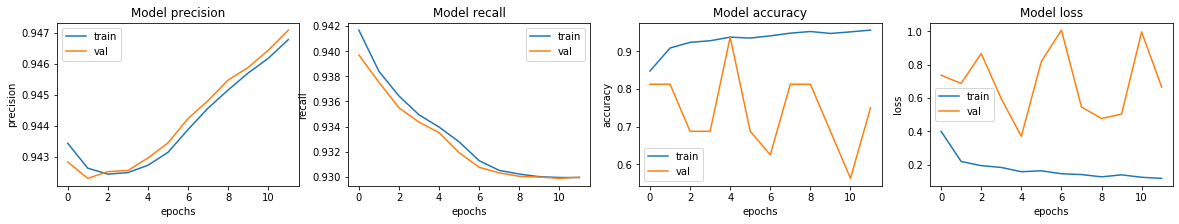

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
loss, acc, prec, rec = cnn1.evaluate(test_set)

20/20 [==============================] - 5s 264ms/step - loss: 0.4126 - accuracy: 0.8766 - precision: 0.9470 - recall: 0.9299


In [36]:
print('test loss = ', loss)
print('test accuracy = ', acc)
print('test precision = ', prec)
print('test recall = ', rec)

test loss =  0.41262945532798767
test accuracy =  0.8766025900840759
test precision =  0.9469577670097351
test recall =  0.9298852682113647


#### CNN Model 4

In [37]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [38]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [39]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(180, 180, 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])
    
    return model

In [40]:
model = build_model()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [41]:
early_stopping = EarlyStopping(
    patience=7, restore_best_weights=True
)
ckpt = ModelCheckpoint(
    filepath = './saved_model/checkpoint/',
    save_best_only = True
)

In [42]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_3 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_4 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [43]:
epochs=100
history = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=epochs,
  callbacks=[ckpt, early_stopping]
)

Epoch 1/100
163/163 [==============================] - 58s 336ms/step - loss: 0.4701 - accuracy: 0.8188 - precision: 0.8040 - recall: 0.8012 - val_loss: 1.2116 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
INFO:tensorflow:Assets written to: ./saved_model/checkpoint\assets
Epoch 2/100
163/163 [==============================] - 55s 338ms/step - loss: 0.2608 - accuracy: 0.9128 - precision: 0.9090 - recall: 0.9095 - val_loss: 1.6023 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 3/100
163/163 [==============================] - 59s 358ms/step - loss: 0.2198 - accuracy: 0.9256 - precision: 0.9237 - recall: 0.9233 - val_loss: 2.0959 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 4/100
163/163 [==============================] - 60s 369ms/step - loss: 0.2009 - accuracy: 0.9245 - precision: 0.9226 - recall: 0.9233 - val_loss: 2.5126 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 5/100
163/163 [

In [44]:
model.metrics_names

['loss', 'accuracy', 'precision', 'recall']

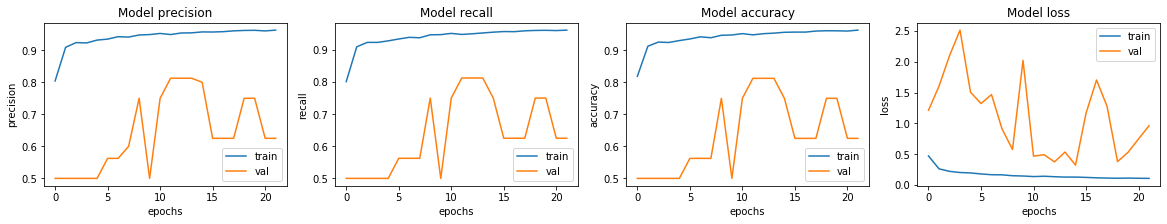

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
loss, acc, prec, rec = model.evaluate(test_set)

20/20 [==============================] - 5s 264ms/step - loss: 0.3143 - accuracy: 0.8638 - precision: 0.8636 - recall: 0.8622


In [47]:
print('test loss = ', loss)
print('test accuracy = ', acc)
print('test precision = ', prec)
print('test recall = ', rec)

test loss =  0.31429728865623474
test accuracy =  0.8637820482254028
test precision =  0.8635634183883667
test recall =  0.8621794581413269
